In [146]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = '/content/gdrive/My Drive/ECE763/'
import numpy as np
import cv2
from scipy.stats import multivariate_normal
from scipy.special import psi, gammaln
from scipy.optimize import fminbound
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import random
from sklearn.preprocessing import StandardScaler
from numpy import matlib


np.random.seed(2)
facetrain= np.load(path+'MyData4/ftrain.npy')
nonfacetrain= np.load(path+'MyData4/nftrain.npy')
facetest= np.load(path+'MyData4/ftest.npy')
nonfacetest= np.load(path+'MyData4/nftest.npy')


Mounted at /content/gdrive


In [0]:
def apply_pca_and_standardize(data,size):
    pca = PCA(n_components=size)
    pca.fit(data)
    data_pca = pca.transform(data)
    scaler = StandardScaler()
    scaler.fit(data_pca)
    data_std = scaler.transform(data_pca)
    return data_std,pca

In [0]:
size = 30
# pca_face = PCA(size)
facetrain_pca,pcaft = apply_pca_and_standardize(facetrain,size) 
nonfacetrain_pca,pcanft = apply_pca_and_standardize(nonfacetrain,size) 
facetest_pca,pcaftest  = apply_pca_and_standardize(facetest,size)
nonfacetest_pca,pcaftrain  = apply_pca_and_standardize(nonfacetest,size)

In [0]:
def fit_mog(x,K,precision):
  lbda = 1/K*np.ones(K).transpose()
  lbda = np.reshape(lbda,(K,1))
  I = x.shape[0]
  K_random_unique_integers = np.random.permutation(I)[0:K]
  mu = x[K_random_unique_integers,:]
  dimensionality = x.shape[1]
  dataset_mean = np.sum(x,axis=0) / I
  dataset_mean = np.reshape(dataset_mean,(1,dataset_mean.shape[0]))
  dataset_variance = np.zeros((dimensionality, dimensionality))

  for i in range(I):
    mat = x[i,:]-dataset_mean
    mat = np.matmul(np.transpose(mat),mat)
    dataset_variance= dataset_variance+mat
  dataset_variance = dataset_variance/I

  sig = []
  for i in range(K):
    sig.append(dataset_variance)
  sig = np.array(sig)


  iterations = 0   
  previous_L = 1000000
  while True:
    l = np.zeros ((I,K))
    r = np.zeros ((I,K))
    for k in range(K):
        l[:,k] = lbda[k] * multivariate_normal.pdf(x, mu[k,:], sig[k],allow_singular=True)


    s = np.sum(l,axis=1)
    for i in range(I):
      r[i,:] = l[i,:] / s[i];

    r_summed_rows = np.sum(r,axis=0)
    r_summed_all = np.sum(r_summed_rows,axis=0)

    for k in range(K):
      lbda[k] = r_summed_rows[k] / r_summed_all
      new_mu = np.zeros((1,dimensionality))
      for i in range(I):
          new_mu = new_mu + r[i,k]*x[i,:]
      mu[k,:] = new_mu/r_summed_rows[k]
      new_sigma = np.zeros((dimensionality,dimensionality))
      for i in range(I):
          mat = x[i,:] - mu[k,:]
          mat = np.reshape(mat,(1,mat.shape[0]))
          mat = r[i,k]*np.matmul(np.transpose(mat),mat)
          new_sigma = new_sigma + mat
      sig[k] = new_sigma/ r_summed_rows[k]

    temp = np.zeros((I,K));
    for k in range(K):
        temp[:,k] = lbda[k] * multivariate_normal.pdf(x, mu[k,:], sig[k],allow_singular=True)
    temp = np.sum(temp,axis=1)
    temp = np.log(temp)      
    L = sum(temp)
    #print('Log-Likelihood: ', L)

    iterations = iterations + 1      
    #print('Iteration number: ',iterations)
    print(np.abs(L - previous_L))
    if np.abs(L - previous_L) < precision:
        break
    previous_L = L
  return lbda,mu,sig



In [150]:
dimm = 20
Xf = facetrain_pca
precision = 0.01
K = 3
af,bf,cf = fit_mog(Xf,K,precision)
Xnf = nonfacetrain_pca
anf,bnf,cnf = fit_mog(Xnf,K,precision)


1 : -42569.40642512214
2 : -42569.319051461454
3 : -42565.12575844783
4 : -42358.9508210107
5 : -40568.02429923517
6 : -39959.75460313396
7 : -39758.063726546905
8 : -39612.02507632482
9 : -39493.28188543438
10 : -39409.19117884658
11 : -39357.531816219765
12 : -39321.65168774703
13 : -39287.734339690964
14 : -39258.81933480935
15 : -39240.25564881998
16 : -39226.17917696317
17 : -39214.476680139254
18 : -39204.97507278978
19 : -39196.294687897076
20 : -39190.594851561895
21 : -39187.75322374472
22 : -39185.556427656884
23 : -39183.76937834048
24 : -39182.2295511751
25 : -39180.750257848325
26 : -39179.11977198533
27 : -39177.06446380321
28 : -39174.311784907135
29 : -39170.932332496726
30 : -39167.54026471856
31 : -39164.72384085797
32 : -39162.58693879599
33 : -39161.02275291944
34 : -39159.88329732304
35 : -39158.94922657241
36 : -39158.114253700674
37 : -39157.33926457443
38 : -39156.587302667234
39 : -39155.82849813123
40 : -39155.0394647186
41 : -39154.172175438194
42 : -39153.17

In [0]:
mu_face    = facetrain_pca.mean(axis=0)
mu_nonface = nonfacetrain_pca.mean(axis=0)
var_face = np.cov(facetrain_pca, rowvar=False, bias=1, ddof=None)
var_face = np.diagonal(var_face)
var_face = np.diag(var_face,0)
var_nonface = np.cov(nonfacetrain_pca, rowvar=False, bias=1, ddof=None)
var_nonface = np.diagonal(var_nonface)
var_nonface = np.diag(var_nonface,0)

In [0]:
Prn2 = np.zeros([100,1])
prob_fpf = np.zeros([100,1])
for k in range(K):
    Prn2 = multivariate_normal.pdf(facetest_pca, bf[k,:], cf[k],allow_singular=True)
    Prn2 = np.reshape(Prn2,(-1,1))
    prob_fpf = prob_fpf + (af[k] * Prn2)
prob_fpnf = multivariate_normal.pdf(facetest_pca, mean= mu_nonface, cov=var_nonface)
P_face = prob_fpf / (prob_fpf+ np.reshape(prob_fpnf,(100,1)))
True_positive = np.sum(P_face[:] >= 0.5)
False_negative = 100 - True_positive

In [153]:
Prn3 = np.zeros([100,1])
prob_nfpnf = np.zeros([100,1])
for k in range(K):
    Prn3 = multivariate_normal.pdf(nonfacetest_pca, bnf[k,:], cnf[k],allow_singular=True)
    Prn3 = np.reshape(Prn3,(-1,1))
    prob_nfpnf = prob_nfpnf + (anf[k] * Prn3)
prob_nfpf = multivariate_normal.pdf(nonfacetest_pca, mean= mu_face, cov=var_face)
P_nonface = prob_nfpnf / (prob_nfpnf+ np.reshape(prob_nfpf,(100,1)))
True_negative = np.sum(P_nonface[:] >= 0.5)
False_positive = 100 - True_negative


fpr =  False_positive/ (False_positive + True_negative)
fnr =  False_negative / (False_negative + True_positive)
miss = ( False_positive+ False_negative) / 200

print('False Positive Rate:',fpr)
print('False Negative Rate:',fnr)
print('Miss Classification Rate:', miss)

False Positive Rate: 0.3
False Negative Rate: 0.36
Miss Classification Rate: 0.33


In [154]:
a = 0
for i in P_face:
  if i>=0.5:
    #print(i)
    a= a+1
print(a)
a = 0
for i in P_nonface:
  if i>=0.5:
    #print(i)
    a= a+1
print(a)

64
70


In [0]:
labels = np.array([np.ones(100),np.zeros(100)])
labels = np.reshape(labels,(200))
X_test_roc = np.array([facetest_pca,nonfacetest_pca])
X_test_roc = np.reshape(X_test_roc,(200,size))

In [0]:
Prn = np.zeros([200,1])
sum1 = np.zeros([200,1])
for k in range(K):
    Prn = multivariate_normal.pdf(X_test_roc, bf[k,:], cf[k],allow_singular=True)
    Prn = np.reshape(Prn,(-1,1))
    sum1 = sum1 + (af[k] * Prn)

sum2 = multivariate_normal.pdf(X_test_roc, mean=mu_nonface, cov=var_nonface,allow_singular=True)
P_Roc = sum1 / (sum1+ np.reshape(sum2,(200,1)))

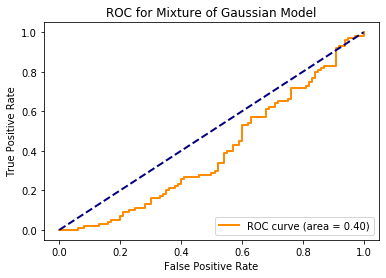

In [157]:
fpr, tpr, thresholds = metrics.roc_curve(labels,P_Roc)
roc_auc = roc_auc_score(labels,P_Roc)
plt.plot(fpr, tpr,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Mixture of Gaussian Model')
plt.legend(loc="lower right")

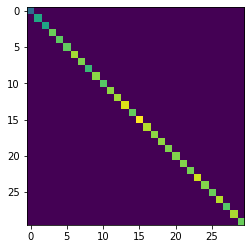

In [160]:
for i in range(K):
  mean_disp = np.dot( pcaft.components_.T,bf[k]) + pcaft.mean_
  mean_disp_new = np.array(mean_disp).astype('uint8')
  mean_disp_new = np.reshape(mean_disp_new,(20,20,3))
  plt.imshow(mean_disp_new)
  plt.savefig('mean'+str(i))
  covariances = np.diag(np.diag(cf[k]))
  plt.imshow(covariances)
  plt.savefig('covariance'+str(i))

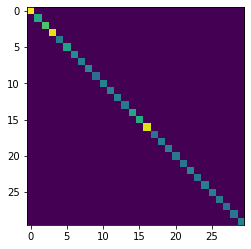

In [162]:
for i in range(K):
  mean_disp = np.dot( pcanft.components_.T,bnf[k]) + pcanft.mean_
  mean_disp_new = np.array(mean_disp).astype('uint8')
  mean_disp_new = np.reshape(mean_disp_new,(20,20,3))
  plt.imshow(mean_disp_new)
  plt.savefig('meannf'+str(i))
  covariances = np.diag(np.diag(cnf[k]))
  plt.imshow(covariances)
  plt.savefig('covariancenf'+str(i))